In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json



In [5]:
! chmod 600 ~/.kaggle/kaggle.json


In [6]:
! kaggle datasets download shubhamgoel27/dermnet

 99% 1.70G/1.72G [00:24<00:00, 95.2MB/s]
100% 1.72G/1.72G [00:24<00:00, 74.5MB/s]


In [ ]:
! unzip dermnet

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [10]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
)

Found 15557 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.


In [11]:
class_names = train_dataset.class_names
class_names


['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

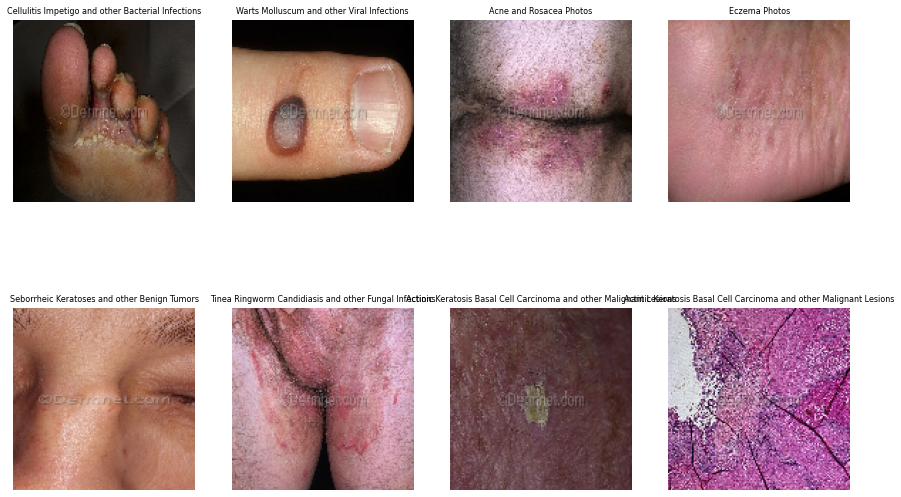

In [12]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train_dataset.take(1):
  for i in range(8):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]],fontsize = 8)
     plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.2,shuffle = True,shuffle_size = 10000):
  assert(train_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds

In [14]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
                     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
model = models.Sequential([
                           resize_and_rescale,
                           layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3) ),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)), 
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)),    
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),    
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(23, activation='softmax')
])
model.build(input_shape = (BATCH_SIZE,128,128,3))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 126, 126, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 63, 63, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 30, 30, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 28, 28, 128)        

In [19]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
EPOCHS = 25
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
) 

Epoch 1/100
195/195 [==============================] - 898s 4s/step - loss: 2.9711 - accuracy: 0.0977 - val_loss: 2.9472 - val_accuracy: 0.1214
Epoch 2/100
195/195 [==============================] - 869s 4s/step - loss: 2.8469 - accuracy: 0.1508 - val_loss: 2.7738 - val_accuracy: 0.1706
Epoch 3/100
195/195 [==============================] - 866s 4s/step - loss: 2.7616 - accuracy: 0.1808 - val_loss: 2.7111 - val_accuracy: 0.1879
Epoch 4/100
195/195 [==============================] - 867s 4s/step - loss: 2.6890 - accuracy: 0.1942 - val_loss: 2.6538 - val_accuracy: 0.2111
Epoch 5/100
 11/195 [>.............................] - ETA: 12:11 - loss: 2.6362 - accuracy: 0.2003

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

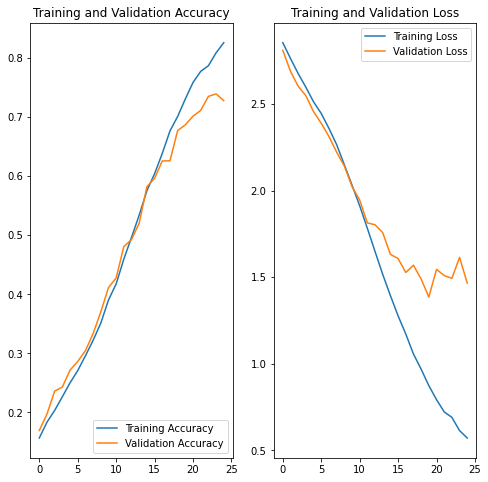

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Psoriasis pictures Lichen Planus and related diseases
predicted label: Eczema Photos


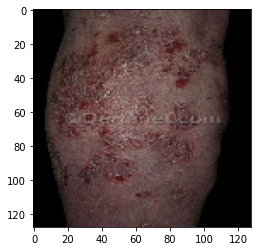

In [26]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[10].numpy().astype('uint8')
    first_label = labels_batch[10].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[10])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

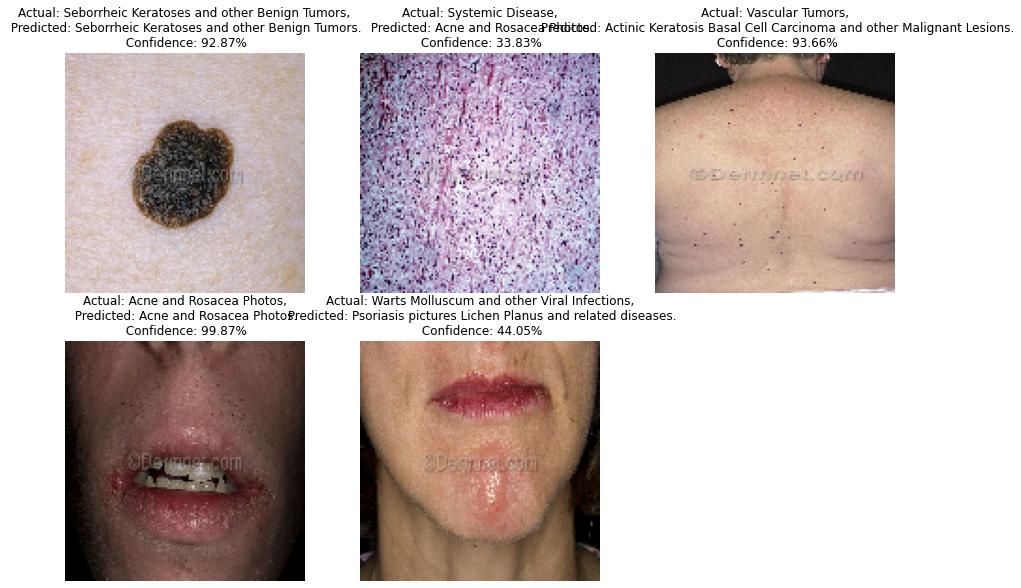

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")